In [1]:
import pandas as pd
import numpy as np
import flip_data
import linear_gd_poisoner
import datetime
import matplotlib.pyplot as plt
from sklearn import linear_model

# Import Training, Testing and Validating Set

In [2]:
poi_train_x = pd.read_csv('train_X.csv')
poi_train_x = np.matrix(poi_train_x.to_numpy())
poi_train_y = pd.read_csv('train_y.csv')
poi_train_y = poi_train_y['Life Expectancy'].tolist()
poi_test_x = pd.read_csv('test_X.csv')
poi_test_x = np.matrix(poi_test_x.to_numpy())
poi_test_y = pd.read_csv('test_y.csv')
poi_test_y = poi_test_y['Life Expectancy'].tolist()
poi_val_x = pd.read_csv('val_X.csv')
poi_val_x = np.matrix(poi_val_x.to_numpy())
poi_val_y = pd.read_csv('val_y.csv')
poi_val_y = poi_val_y['Life Expectancy'].tolist()

In [3]:
# num of points to train model
train_ct = len(poi_train_x)
test_ct = len(poi_test_x)
print ("Train count: ", train_ct, " Test count: ", test_ct)

Train count:  1319  Test count:  165


In [4]:
def compute_error(classifier, plot, poisoned):
    # Compute predicted values
    test_y_pred = classifier.predict(poi_test_x)
    valid_y_pred = classifier.predict(poi_val_x)
    if (plot is True):
        plt.scatter(poi_test_y, test_y_pred)
        if (poisoned is True):
            plt.title("Flipped & Poisoned")
        else:
            plt.title("Flipped")
        plt.xlabel("Testing Data")
        plt.ylabel("Testing Predicted")
        plt.show()
        plt.scatter(poi_val_y, valid_y_pred)
        plt.xlabel("Validation Data")
        plt.ylabel("Validation Predicted")
        plt.show()
    # Compute squared errors
    test_mse = np.mean((test_y_pred - poi_test_y) ** 2)
    valid_mse = np.mean((valid_y_pred - poi_val_y) ** 2)
    return valid_mse, test_mse

# Inverse Flip and Linear Reg Poisoner

classifier:  LinearRegression()


*****************************
**** Poison Count:  54  ****
*****************************
Initial Iteration 
Current Loss:  0.006645032871126786
Validation MSE  0.005291978574315283 
Test MSE  0.0069904013734772225
 
Iteration  1
Loss: 0.0057946364100228435  Difference:  -0.0008503964611039421
NO PROGRESS MADE!
 
Iteration  2
Loss: 0.005761115811117407  Difference:  -0.0008839170600093782
NO PROGRESS MADE!
 
Iteration  3
Loss: 0.005758844389327281  Difference:  -0.0008861884817995044
NO PROGRESS MADE!
 
Iteration  4
Loss: 0.005757584855866518  Difference:  -0.0008874480152602678
NO PROGRESS MADE!
 
Iteration  5
Loss: 0.005729469981137278  Difference:  -0.0009155628899895074
NO PROGRESS MADE!
 
Iteration  6
Loss: 0.005729169634967068  Difference:  -0.0009158632361597179
NO PROGRESS MADE!
 
Iteration  7
Loss: 0.005729053478610583  Difference:  -0.0009159793925162026
NO PROGRESS MADE!
 
Iteration  8
Loss: 0.005729005062837047  Difference:  -0.0009160278082

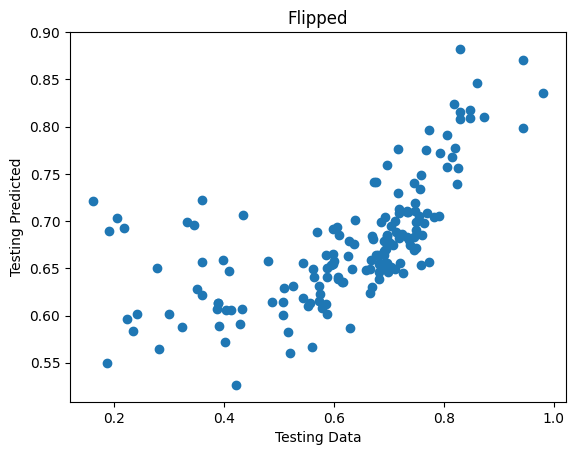

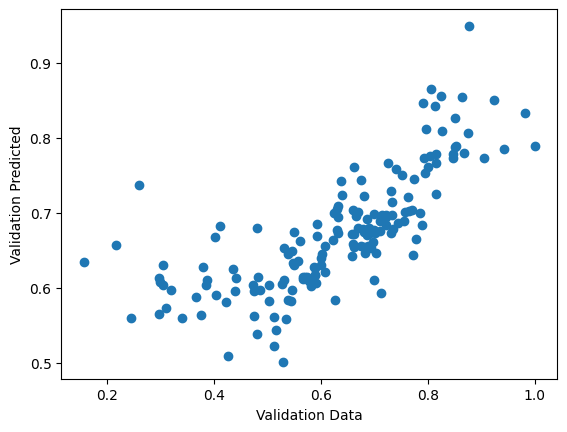

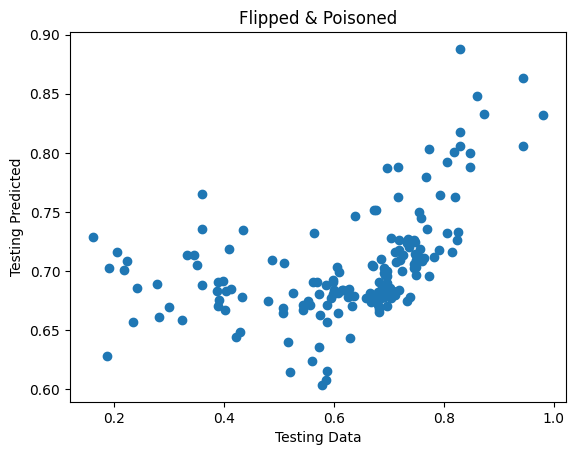

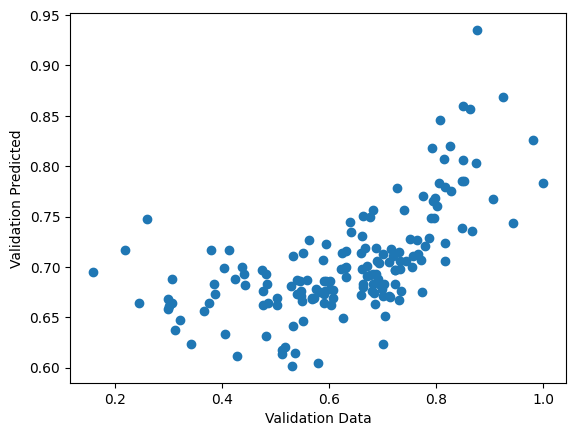


Poison Proportion:  20.0 %. Max reached, terminate

After Flipping, Unpoisoned 
 Validation MSE:  0.015574755191238883 
 Test MSE: 0.02164159973932082

After Flipping & Poisoning:
 Validation MSE:  0.02438655591265006 
 Test MSE: 0.029856182214325875


In [5]:
# define parameters for poisoner
eta = 0.01 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-4 # poisoning stop condition
stop1 = 5
stop2 = 20
stop3 = 10
decrease_rate = 0.65

poiser = linear_gd_poisoner.poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
"""
Evaluate the poisoning attack with the poison rate of 4%, 8%, 12%, 16%, 20%
"""
for i in [0.04, 0.08, 0.12, 0.16, 0.20]:
    # calculate the amt of data that should be poisoned in this iteration
    sample_amt = int(train_ct*(i/(1 - i)))
    # flip the data
    x_flip, y_flip = flip_data.flip_data.inverse_flip(poi_train_x,poi_train_y,sample_amt)
    classifier = linear_model.LinearRegression()
    classifier.fit(np.vstack((poi_train_x, x_flip)), poi_train_y + y_flip,)
    print("classifier: ", classifier)
    err = compute_error(classifier,False,False)[0]
    # Get the current time before running the code
    start_time = datetime.datetime.now()
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(np.matrix(x_flip), y_flip[:],stop1, stop2, stop3, decrease_rate)
    x_poised = np.vstack((poi_train_x,x_pois_result))
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised = linear_model.LinearRegression()
    classifier_poised.fit(x_poised,y_poised)
    # Get the current time after running the code
    end_time = datetime.datetime.now()
    print("Poisoned classifier: ", classifier_poised)
    # Calculate the difference between the start and end times
    time_diff = end_time - start_time
    print("Total running time (seconds):", time_diff.total_seconds())
    classifier = poiser.init_classifier
    if i != 0.20:
        err_unpoised = compute_error(classifier,False,False)
        err = compute_error(classifier_poised,False,False)
        print("\nPoison Proportion: ", i*100,"%")
    else:
        err_unpoised = compute_error(classifier,True,False)
        err = compute_error(classifier_poised,True,True)
        print("\nPoison Proportion: ", i*100, "%. Max reached, terminate")
    print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
    print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])

# Perform B Flip and Linear Reg Poisoning

classifier:  LinearRegression()


*****************************
**** Poison Count:  54  ****
*****************************
Initial Iteration 
Current Loss:  0.005495161978433498
Validation MSE  0.004497480607636135 
Test MSE  0.005448635729458156
 
Iteration  1
Loss: 0.004881844935597767  Difference:  -0.000613317042835731
NO PROGRESS MADE!
 
Iteration  2
Loss: 0.004882651016725388  Difference:  -0.0006125109617081109
NO PROGRESS MADE!
 
Iteration  3
Loss: 0.004881460383176837  Difference:  -0.0006137015952566612
NO PROGRESS MADE!
 
Iteration  4
Loss: 0.004881011299848873  Difference:  -0.0006141506785846251
NO PROGRESS MADE!
 
Iteration  5
Loss: 0.004880811575024763  Difference:  -0.0006143504034087357
NO PROGRESS MADE!
 
Iteration  6
Loss: 0.004880752471957251  Difference:  -0.000614409506476247
NO PROGRESS MADE!
 
Iteration  7
Loss: 0.0048807131511261915  Difference:  -0.0006144488273073069
NO PROGRESS MADE!
 
Iteration  8
Loss: 0.0048806589734447  Difference:  -0.000614503004988798

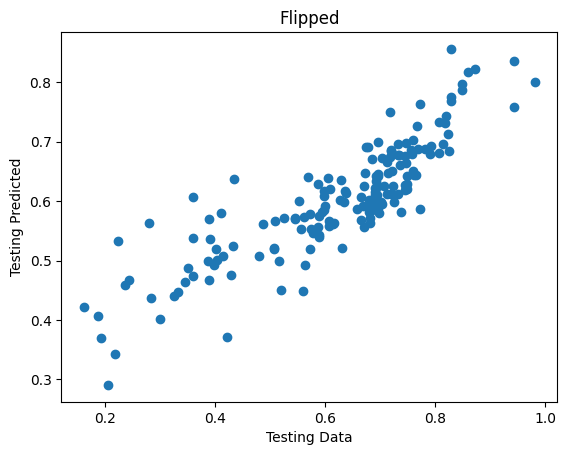

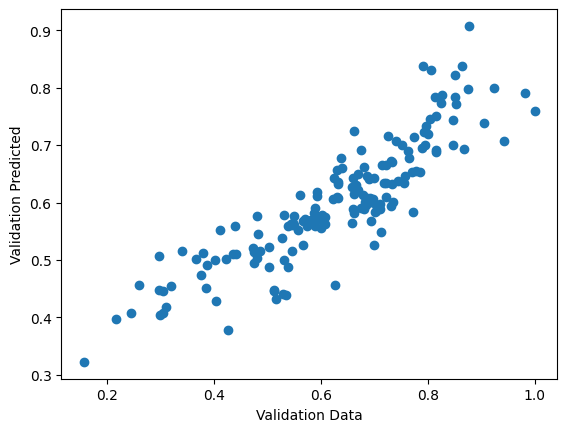

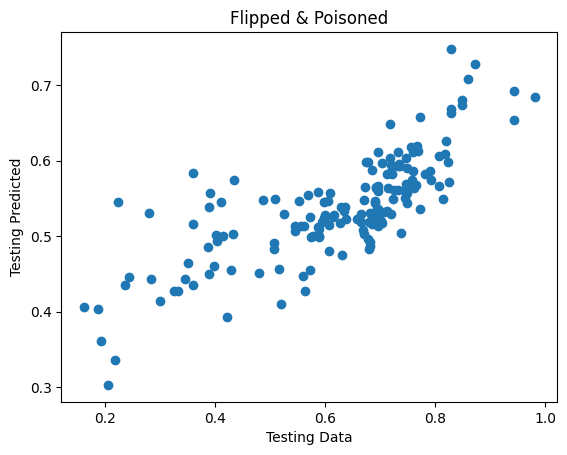

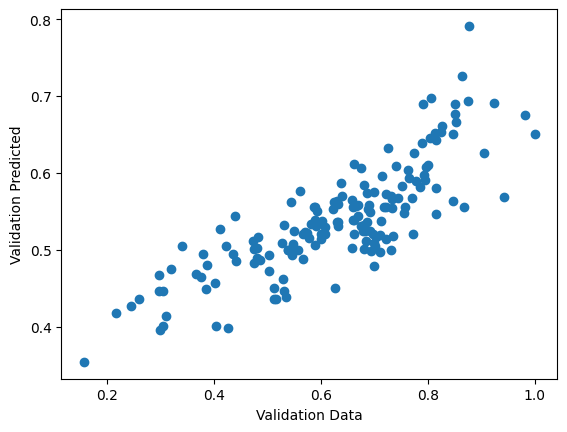


Poison Proportion:  20.0 %. Max reached, terminate

After Flipping, Unpoisoned 
 Validation MSE:  0.008283362477791186 
 Test MSE: 0.01013192160274636

After Flipping & Poisoning:
 Validation MSE:  0.020882551402214858 
 Test MSE: 0.02229551872517496


In [6]:
poiser = linear_gd_poisoner.poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
"""
Evaluate the poisoning attack with the poison rate of 4%, 8%, 12%, 16%, 20%
"""
for i in [0.04, 0.08, 0.12, 0.16, 0.20]:
    # calculate the amt of data that should be poisoned in this iteration
    sample_amt = int(train_ct*(i/(1 - i)))
    # flip the data
    x_flip, y_flip = flip_data.flip_data.B_flip(poi_train_x,poi_train_y,sample_amt)
    classifier = linear_model.LinearRegression( )
    classifier.fit(np.vstack((poi_train_x, x_flip)), poi_train_y + y_flip,)
    print("classifier: ", classifier)
    err = compute_error(classifier,False,False)[0]
    # Get the current time before running the code
    start_time = datetime.datetime.now()
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(np.matrix(x_flip), y_flip[:],stop1, stop2, stop3, decrease_rate)
    x_poised = np.vstack((poi_train_x,x_pois_result))
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised = linear_model.LinearRegression( )
    classifier_poised.fit(x_poised,y_poised)
    # Get the current time after running the code
    end_time = datetime.datetime.now()
    print("Poisoned classifier: ", classifier_poised)
    # Calculate the difference between the start and end times
    time_diff = end_time - start_time
    print("Total running time (seconds):", time_diff.total_seconds())
    classifier = poiser.init_classifier
    if i != 0.20:
        err_unpoised = compute_error(classifier,False,False)
        err = compute_error(classifier_poised,False,False)
        print("\nPoison Proportion: ", i*100,"%")
    else:
        err_unpoised = compute_error(classifier,True,False)
        err = compute_error(classifier_poised,True,True)
        print("\nPoison Proportion: ", i*100, "%. Max reached, terminate")
    print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
    print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])